# Flysight GPS

![Drag Racing](../img/product.jpg)

**FlySight is not your mother's GPS.**

FlySight was designed from the ground up for wingsuit pilots and does one truly revolutionary thing...

**FlySight provides real-time audible indication of glide ratio, horizontal or vertical speed.**

If you've used other GPS receivers, you know the drill. When you land, you review data from the jump. If you're lucky, or if you've planned a very simple jump, you might remember what you were doing when your glide ratio maxed out. On the next jump, you try to do it again.

**FlySight speeds the learning process.**

When you change your body position, you instantly hear a change in the tone. Your brain easily connects this feedback with your precise body position, making it astonishingly easy to remember what worked and what didn't.

### Data produced

https://www.monocilindro.com/wp-content/uploads/2016/03/u-blox6-Receiver-Description-Protocol-Specification.pdf
https://www.monocilindro.com/2017/02/22/gps-data-logger-using-arduino-unonano-and-ublox-neo-6m/


| Data   | Unity  | Meaning                                |
| :----- | :----- | :------------------------------------- |
| time   | object | time                                   |
| lat    | deg    | latitude                               |
| lon    | deg    | longitude                              |
| hMSL   | m      | Height Above sea level                 |
| velN   | m/s    | NED north velocity                     |
| velE   | m/s    | NED east velocity                      |
| velD   | m/s    | NED down velocity                      |
| hAcc   | m      | Horizontal Accuracy Estimate           |
| vAcc   | m      | Vertical Accuracy Estimate             |
| sAcc   | m/s    | Speed Accuracy Estimate                |
| gpsFix |        | Position Fix Flags in NMEA MODE        |
| numSV  |        | Number of per-SV data blocks following |

### Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import plotly.express as px
import datetime as dt
from math import radians, cos, sin, asin, sqrt, degrees, atan
import requests
import urllib
import itertools
import time
import peakutils as pu
import geopy.distance

In [169]:
# inlezen van de dataset
data = pd.read_csv('../data/J1.csv', skiprows=[1])
data.head()

,time,lat,lon,hMSL,velN,velE,velD,hAcc,vAcc,sAcc,heading,cAcc,gpsFix,numSV
0,2022-06-22T11:45:46.80Z,56.183217,9.040273,-22.772,2.44,-0.89,-4.79,174.336,295.980,7.29,340.00856,35.79024,3,6
1,2022-06-22T11:45:47.00Z,56.183230,9.040298,-22.027,1.85,-0.27,-1.84,103.671,152.919,3.80,344.61396,44.06033,3,5
2,2022-06-22T11:45:47.20Z,56.183236,9.040297,-24.504,1.73,-0.93,-1.26,107.556,163.691,3.75,335.28268,27.61818,3,4
3,2022-06-22T11:45:47.40Z,56.183298,9.040240,-18.407,0.90,-0.70,-1.05,90.334,140.775,3.19,335.28268,27.62859,3,6
4,2022-06-22T11:45:47.60Z,56.183349,9.040209,-10.147,0.21,-0.13,-0.86,74.252,119.369,2.77,335.28268,27.63762,3,5


In [170]:
# Helper functions

def meters_to_feet(meters):
    return meters * 3.280839895

def feet_to_meters(feet):
    return feet / 3.280839895

def meterpersecond_to_milesperhour(meterpersecond):
    return meterpersecond * 2.236936

def meterpersecond_to_kilometersperhour(meterpersecond):
    return meterpersecond * 3.6

def calc_horizontal_speed(n, e):
    return sqrt((n**2) + (e**2))

def calc_dive_angle(v_speed, h_speed):
    try:
        return degrees(atan(v_speed/h_speed))
    except ZeroDivisionError:
        return 0   

def cal_distance_geo(lat1, lat2, lon1, lon2):
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geopy.distance.geodesic(coords_1, coords_2).miles

In [171]:
# Dataset

class Dataset:
    def __init__(self, name, df):
        self.name = name
        self.old_df = df 
        self.df = self.update_df()
        
    def get_total_seconds(self):
        datetimes = [pd.to_datetime(d) for d in self.old_df.time]
        l = []
        for i, d in enumerate(datetimes):
            duration = datetimes[i] - datetimes[0]
            l.append(duration.total_seconds())
        return l

    def get_fixed_elevation(self, elevation):
        ground_elevation = meters_to_feet(self.old_df.hMSL.iloc[-1])
        return [meters_to_feet(self.old_df.hMSL[i]) - ground_elevation - elevation for i in range(0, len(self.old_df.hMSL))]

    def get_vertical_speed(self, metric):
        if metric == 'mph':
            return [meterpersecond_to_milesperhour(meter) for meter in self.old_df.velD]
        elif metric == 'km/u':
            return [meterpersecond_to_kilometersperhour(meter) for meter in self.old_df.velD]
        else:
            raise ValueError('Invalid metric')

    def get_horizontal_speed(self, metric):
        speed = [calc_horizontal_speed(self.old_df.velN[i], self.old_df.velE[i]) for i in range(0, len(self.old_df))]
        if metric == 'mph':
            return [meterpersecond_to_milesperhour(s) for s in speed]
        elif metric == 'km/u':
            return [meterpersecond_to_kilometersperhour(s) for s in speed]
        else:
            raise ValueError('Invalid metric')

    def get_dive_angle(self, v_speed, h_speed):
        return [calc_dive_angle(v_speed[i], h_speed[i]) for i in range(0, len(self.old_df))]

    def get_horizontal_distance(self):
        l, f = [0], 0.0
        for i in range(0, len(self.old_df)-1):
            f += cal_distance_geo(self.old_df.lat[i], self.old_df.lat[i+1], self.old_df.lon[i], self.old_df.lon[i+1]) * 5280
            l.append(f)
        return l

    def update_df(self):
        return pd.DataFrame({
            'time': np.array(self.get_total_seconds()),
            'lat': self.old_df.lat,
            'lon': self.old_df.lon,
            'elevation': self.get_fixed_elevation(0),
            'horz_distance': self.get_horizontal_distance(),
            'vert_speed_mph': self.get_vertical_speed('mph'),
            'horz_speed_mph': self.get_horizontal_speed('mph'),
            'vert_speed_km': self.get_vertical_speed('km/u'),
            'horz_speed_km': self.get_horizontal_speed('km/u'),
            'dive_angle': self.get_dive_angle(self.get_vertical_speed('mph'), self.get_horizontal_speed('mph'))})        
    
    def copy(self):
        self.df.to_csv(f'.\\data\\test-v1-{self.name}')

    def get_df(self):
        return self.df

    def __str__ (self):
            return f'{self.name}'

In [172]:
dataset = Dataset("flysight_v1", data)
df = dataset.get_df()
df.head(10)

,time,lat,lon,elevation,horz_distance,vert_speed_mph,horz_speed_mph,vert_speed_km,horz_speed_km,dive_angle
0,0.0,56.183217,9.040273,-207.821522,0.000000,-10.714923,5.809879,-17.244,9.350095,-61.532429
1,0.2,56.183230,9.040298,-205.377297,7.093672,-4.115962,4.182173,-6.624,6.730556,-44.542847
2,0.4,56.183236,9.040297,-213.503937,9.145866,-2.818539,4.393629,-4.536,7.070862,-32.680413
3,0.6,56.183298,9.040240,-193.500656,34.751788,-2.348783,2.550499,-3.780,4.104632,-42.642310
4,0.8,56.183349,9.040209,-166.400919,54.445333,-1.923765,0.552482,-3.096,0.889134,-73.976563
5,1.0,56.183423,9.040161,-130.810367,82.932780,-2.438260,0.368925,-3.924,0.593727,-81.396032
6,1.2,56.183453,9.040129,-121.167979,95.684812,-2.661954,0.360695,-4.284,0.580483,-82.283412
7,1.4,56.183477,9.040107,-110.682415,105.518130,-2.706693,0.364147,-4.356,0.586038,-82.337680
8,1.6,56.183490,9.040096,-102.923228,111.061471,-2.125089,1.449873,-3.420,2.333344,-55.695672
9,1.8,56.183485,9.040088,-107.326115,113.608507,-1.968504,1.202548,-3.168,1.935314,-58.579470


In [173]:
# Move y-axis
def change_point(dataframe, key, col):
    k = dataframe.iloc[:key][::-1][col].reset_index()
    k.iloc[:-1] *= -1
    j = [round(s + k[col][0], 4) for s in dataframe.iloc[key:][col]]
    return np.concatenate((k[col], j))

def move_yaxis(dataframe, key):
    dataframe.time = change_point(dataframe, key, 'time')
    dataframe.horz_distance = change_point(dataframe, key, 'horz_distance')
    return dataframe

#df2 = df
#df2 = move_yaxis(df2, 2722)
#df2.tail(10)

### Get time of skydive

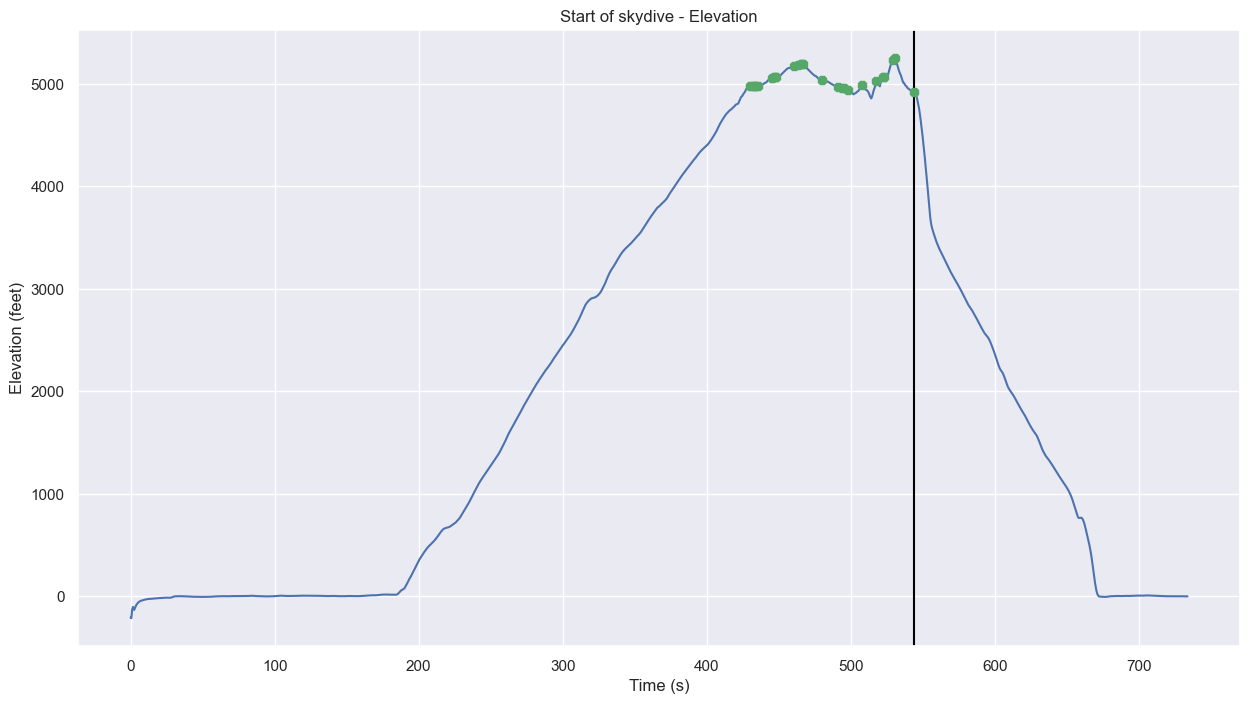

key: 2719 ; time(s): 543.8


In [174]:
def start_skydive_elevation(df):
    return pu.indexes(df.elevation, thres=0.9, min_dist=1)[-1]

def plt_start_skydive_elevation(x, y):
    peaks = pu.indexes(y, thres=0.9, min_dist=1)
    
    plt.figure(figsize=(15,8))    
    plt.plot(x, y)
    plt.axvline(x = x[peaks[-1]], color = 'black', label = 'axvline - full height')
    plt.plot(x[peaks], y[peaks], marker="8", color='g', ls="")
    plt.title("Start of skydive - Elevation")
    plt.xlabel("Time (s)")
    plt.ylabel("Elevation (feet)")
    plt.show()
    print(f'key: {peaks[-1]} ; time(s): {x[peaks[-1]]}')
    
plt_start_skydive_elevation(df.time, df.elevation)

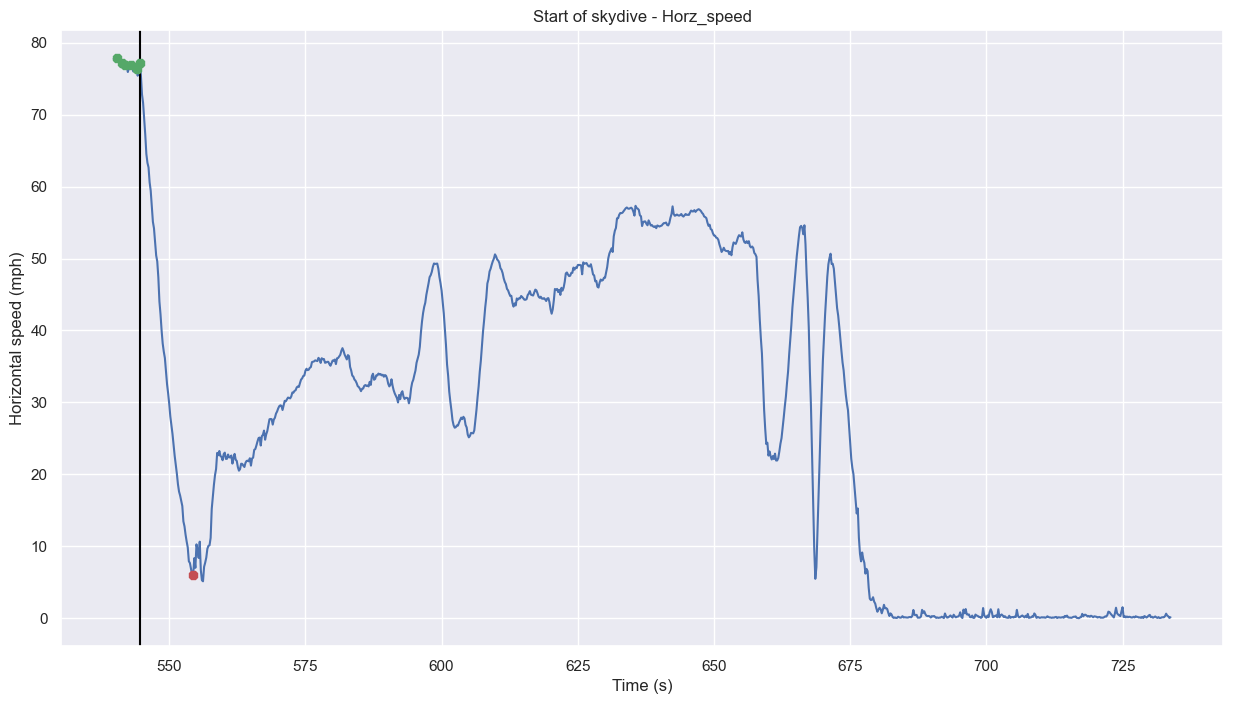

key: 24 ; time(s): 544.6


In [175]:
def plt_skydive_horz_speed(x, y):
    peaks = pu.indexes(y, thres=0.95, min_dist=1)
    lows = pu.indexes(-y, 0.85, 1)
    first_peak = [p for p in peaks if p < lows[0]]
    
    plt.figure(figsize=(15,8))    
    plt.plot(x, y)
    plt.axvline(x = x[first_peak[-1]], color = 'black', label = 'axvline - full height')
    plt.plot(x[peaks], y[peaks], marker="8", color='g', ls="")
    plt.plot(x[lows[0]], y[lows[0]], marker="8", color='r', ls="")
    plt.title("Start of skydive - Horz_speed")
    plt.xlabel("Time (s)")
    plt.ylabel("Horizontal speed (mph)")
    plt.show()
    
    print(f'key: {first_peak[-1]} ; time(s): {x[first_peak[-1]]}')
    
key = start_skydive_elevation(df) - 20
jmp_df = df.iloc[key:]
jmp_df = jmp_df.reset_index()
    
plt_skydive_horz_speed(jmp_df.time, jmp_df.horz_speed_mph)

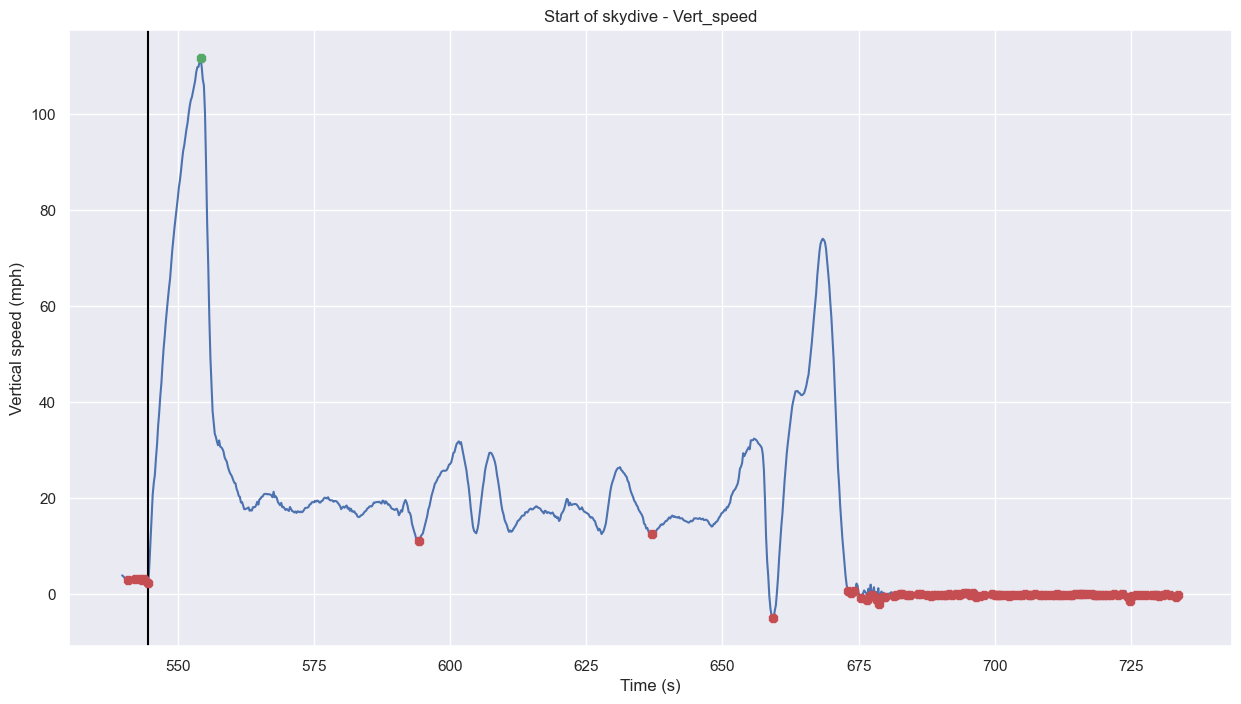

key: 24 ; time(s): 544.6


In [176]:
def plt_skydive_vert_speed(x, y):
    peaks = pu.indexes(y, thres=0.9, min_dist=1)
    lows = pu.indexes(-y, 0.85, 1)
    drop = [l for l in lows if l < peaks[0]]

    plt.figure(figsize=(15,8))    
    plt.plot(x, y)
    plt.axvline(x = x[drop[-1]], color = 'black', label = 'axvline - full height')
    plt.plot(x[peaks], y[peaks], marker="8", color='g', ls="")
    plt.plot(x[lows], y[lows], marker="8", color='r', ls="")
    plt.title("Start of skydive - Vert_speed")
    plt.xlabel("Time (s)")
    plt.ylabel("Vertical speed (mph)")
    plt.show()
    
    print(f'key: {drop[-1]} ; time(s): {x[drop[-1]]}')

plt_skydive_vert_speed(jmp_df.time, jmp_df.vert_speed_mph)

In [177]:
def closest_value(input_list, input_value):
    difference = lambda input_list : abs(input_list - input_value)
    res = min(input_list, key=difference)
    return res

def get_skydive():
    # Elevation
    offset = pu.indexes(df.elevation, thres=0.9, min_dist=1)[-1] - 20
    jmp_df = df.iloc[key:]
    jmp_df = jmp_df.reset_index()
    
    # Horz speed
    horz_speed_peaks = pu.indexes(jmp_df.horz_speed_mph, thres=0.95, min_dist=1)
    horz_speed_lows = pu.indexes(-jmp_df.horz_speed_mph, thres=0.85, min_dist=1)
    peak = [p for p in horz_speed_peaks if p < horz_speed_lows[0]]

    # Vert speed
    vert_speed_peaks = pu.indexes(jmp_df.vert_speed_mph, thres=0.9, min_dist=1)
    vert_speed_lows = pu.indexes(-jmp_df.vert_speed_mph, thres=0.85, min_dist=1)
    drop = [l for l in vert_speed_lows if l < vert_speed_peaks[0]]
    
    test = np.mean([jmp_df.time[drop[-1]], jmp_df.time[peak[-1]]])
    return df.index[df['time'] == closest_value(df.time, test)][0]
    


In [178]:
df = move_yaxis(df, get_skydive())
df.head(10)

,time,lat,lon,elevation,horz_distance,vert_speed_mph,horz_speed_mph,vert_speed_km,horz_speed_km,dive_angle
0,-544.4,56.183217,9.040273,-207.821522,-64943.598068,-10.714923,5.809879,-17.244,9.350095,-61.532429
1,-544.2,56.183230,9.040298,-205.377297,-64922.020024,-4.115962,4.182173,-6.624,6.730556,-44.542847
2,-544.0,56.183236,9.040297,-213.503937,-64900.285994,-2.818539,4.393629,-4.536,7.070862,-32.680413
3,-543.8,56.183298,9.040240,-193.500656,-64878.482250,-2.348783,2.550499,-3.780,4.104632,-42.642310
4,-543.6,56.183349,9.040209,-166.400919,-64855.960440,-1.923765,0.552482,-3.096,0.889134,-73.976563
5,-543.4,56.183423,9.040161,-130.810367,-64833.442576,-2.438260,0.368925,-3.924,0.593727,-81.396032
6,-543.2,56.183453,9.040129,-121.167979,-64811.186247,-2.661954,0.360695,-4.284,0.580483,-82.283412
7,-543.0,56.183477,9.040107,-110.682415,-64788.307235,-2.706693,0.364147,-4.356,0.586038,-82.337680
8,-542.8,56.183490,9.040096,-102.923228,-64765.226734,-2.125089,1.449873,-3.420,2.333344,-55.695672
9,-542.6,56.183485,9.040088,-107.326115,-64742.076197,-1.968504,1.202548,-3.168,1.935314,-58.579470


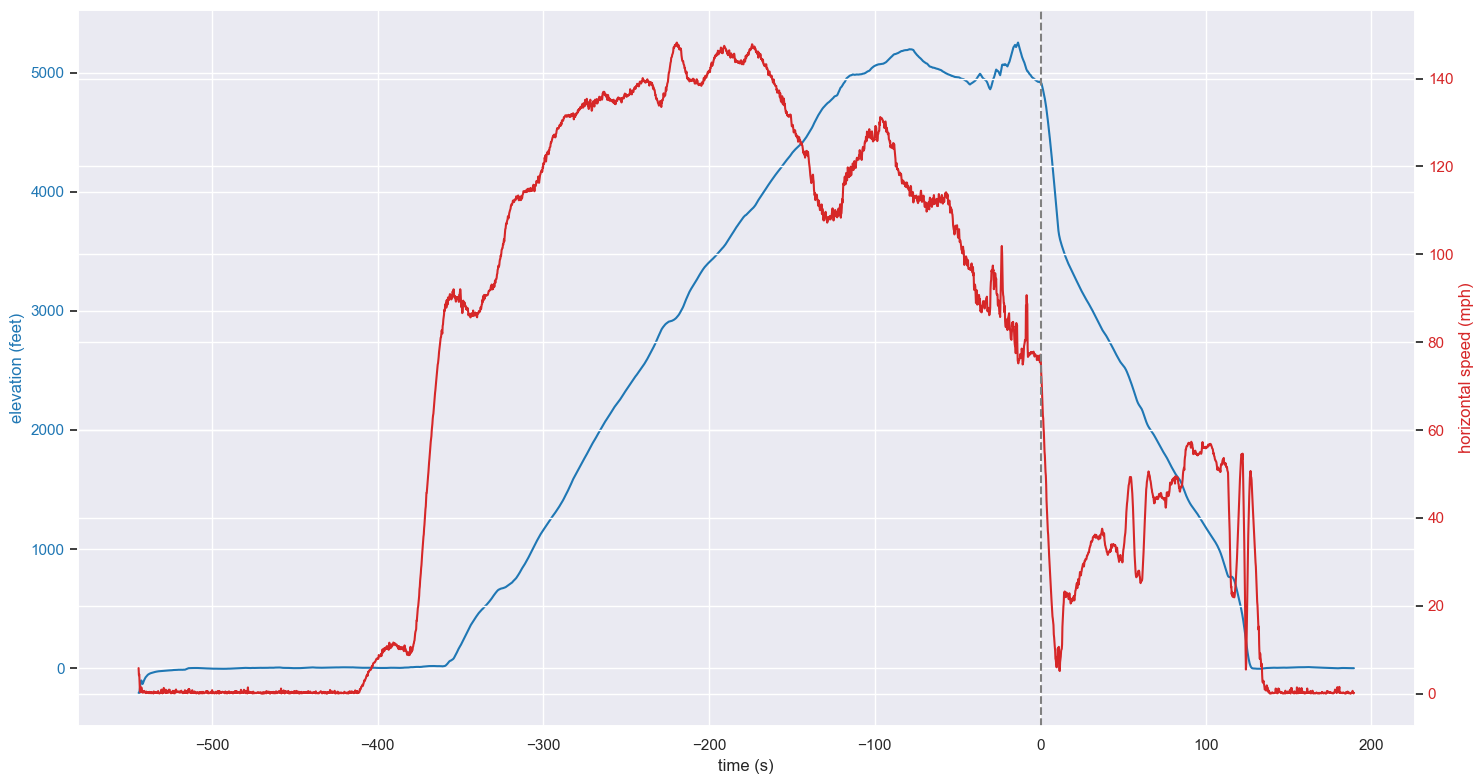

In [179]:
fig, ax1 = plt.subplots(figsize=(15,8))

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('elevation (feet)', color=color)
ax1.plot(df.time, df.elevation, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('horizontal speed (mph)', color=color)  # we already handled the x-label with ax1
ax2.plot(df.time, df.horz_speed_mph, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axvline(x = df.time[get_skydive()], color = 'grey', linestyle ="--")
plt.show()

In [157]:
def get_landing():
    max_id = df.fixed_elevation.idxmax()
    start_of_jump = df.iloc[max_id:]
    return start_of_jump.loc[start_of_jump.fixed_elevation <= 1200]

In [749]:
def get_max_horizontal_speed(dataframe):
    return [dataframe.horizontal_speed.idxmax(), dataframe.horizontal_speed.max()]

get_max_horizontal_speed(get_landing())

[7259, 60.776382007128724]

## Visualisations

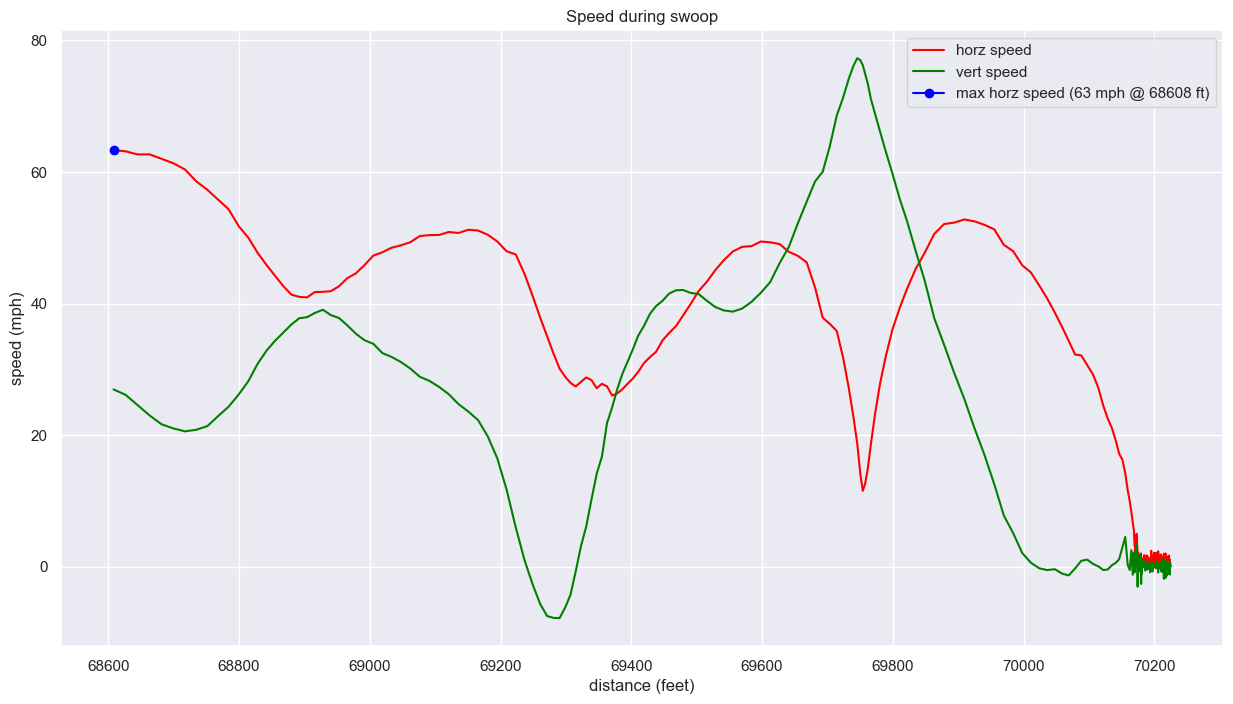

In [376]:
# Speed during swoop
landing = get_landing()
landing = landing.reset_index()

def plot_speed_during_swoop(dataframe):
    max_id = get_max_horizontal_speed(dataframe)[0]
    max_horz_distance = dataframe.horizontal_distance[max_id]
    max_horz_speed = dataframe.horizontal_speed[max_id]

    plt.figure(figsize=(15,8))
    plt.title("Speed during swoop")
    plt.plot(dataframe.horizontal_distance.iloc[max_id:], dataframe.horizontal_speed.iloc[max_id:], color='red', label='horz speed')
    plt.plot(dataframe.horizontal_distance.iloc[max_id:], dataframe.vertical_speed.iloc[max_id:], color='green', label='vert speed')
    plt.plot(max_horz_distance, max_horz_speed, 
             marker="o", color='blue', label=f"max horz speed ({round(max_horz_speed)} mph @ {round(max_horz_distance)} ft)")
    plt.legend()   
    plt.xlabel("distance (feet)")
    plt.ylabel("speed (mph)")
    plt.show()
    
plot_speed_during_swoop(landing)

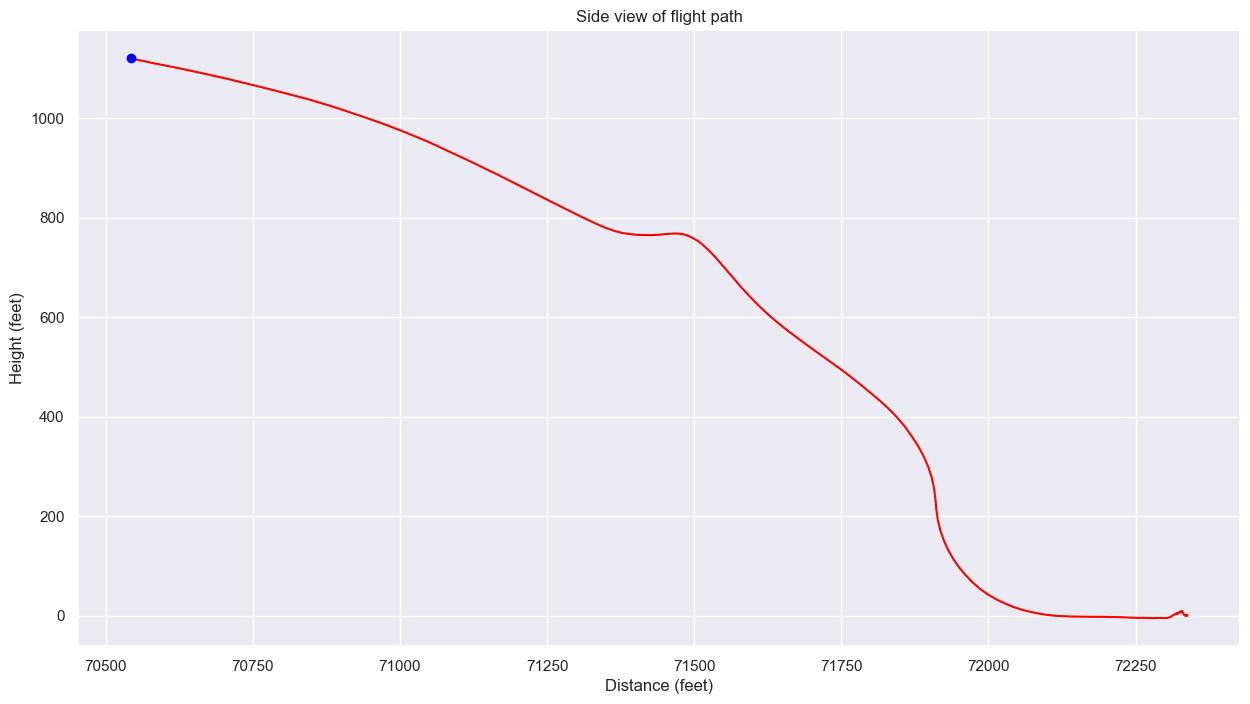

In [21]:
# Side view of flight path
def side_flight_path(dataframe):
    max_id = get_max_horizontal_speed(dataframe)[0]
    max_horz_distance = dataframe.horizontal_distance[max_id]

    plt.figure(figsize=(15,8))
    plt.title("Side view of flight path")
    plt.plot(dataframe.horizontal_distance.iloc[max_id:], dataframe.fixed_elevation[max_id:], color='red')
    plt.plot(dataframe.horizontal_distance[max_id], dataframe.fixed_elevation[max_id], marker="o", color='blue')
    plt.xlabel("Distance (feet)")
    plt.ylabel("Height (feet)")
    plt.show()
    
side_flight_path(landing)

In [750]:
fig = px.line(df, x="time", y="fixed_elevation")
fig.update_traces(mode="lines")
fig.update_xaxes(showspikes=True, spikecolor="black", spikethickness=0.5)
fig.update_yaxes(showspikes=True, spikecolor="black", spikethickness=0.5)
fig.show()

In [24]:
token = "pk.eyJ1IjoiYWlieWJydW0iLCJhIjoiY2xhdmRldnhyMDRkNTNybWg0NTl6eHgwZSJ9.phqQCg9UWIXx5wFkc_i0kg"

fig = px.line_mapbox(df, lat="lat", lon="lon", zoom=12)
fig.update_layout(mapbox_style="satellite-streets", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()